# Actief
This is the first label of our dataset we'll try to predict.
## Details
> Een actieve of passieve constructie wijst op de vorm die  het  werkwoord  aanneemt  in  de  zin.  Er  zouden eerder   actieve   constructies   worden   gebruikt   in koppen, dan passieve.Ook   verstaan   we   in   deze   studie   onder   actieve constructies koppen die directer overkomen dan hun concurrentie, die misschien wat meer omslachtig is.Bij  een  directe  kop  staat  het  hoofdnieuws  van  het artikel vooraan, een indirectere kop geeft eerst nog watalgemene of onbeduidende informatie.
## Example
> Actief: Weg met perfectie: H&M werktde kleine details van bikinimodellen niet langer weg
> Passief:  Weg  met  perfectie:  striemen,  beharing en littekens     van badpakmodellen H&M (worden) niet langer gefotoshopt
> Directer: Proximus werktaan  eigen  Belgische Netflix
> Indirecter: Proximus denktaan  eigen  Belgische Netflix
## Data

In [5]:
from util import get_cls_train_test

train_x, train_y, test_x, test_y = get_cls_train_test("Actief")
train_y.value_counts()

1    567
0    114
Name: Actief, dtype: int64

## Approach 1: Past paricle using own function
A passive construction will often contain a past particle, so it might be useful to train a model to search for those. However, this won't be an ideal scenario, since more indirect forms (like the one given above using "to think") will be ignored with this.
In the English language, we have following markers for a passive construction: be, -ed and by ([src](https://www.academypublication.com/issues/past/jltr/vol01/06/32.pdf), Classification and SLA Studies of Passive Voice, Yuanying Wang). This translates in dutch to forms of "worden", "ge-" and "door".

In [6]:
# Warning: This manually writtn functions are prone to overfitting, so it's better to actually use nlp methods
def is_passive(headline):
    # TODO: Maybe I can check this with spacy? Since this manual construction is probbly overfitting

    # Check if any word in headline start with "ge"
    for word in headline.split():
        if word.startswith("ge") or word.startswith("Ge"):
            return True
        if word == "door" or word == "Door":
            return True
        if "word" in word or word in ["zijn", "is", "ben", "bent"]:  # Check for any form of the verb "worden"
            return True
    return False


def is_active(headline):
    return not is_passive(headline)


print(is_passive("Verdachte gevlucht na overval"))

True


f-score: 0.584192439862543
Confusion matrix: (TP: 21, FP: 18, FN: 103, TN: 85)
Accuracy=46.70% (106/227)


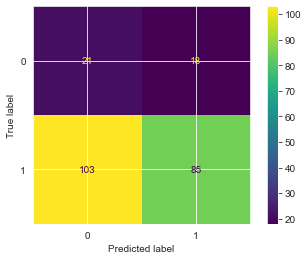

In [7]:
from util import print_evaluation
import numpy as np

predictions = np.vectorize(is_passive)(test_x)
print_evaluation(test_y, predictions)

Too much words starting with “Ge-” (e.g. Geen,gewoon, gebouw, …) are seen as passive indications, even though they aren’t. Let’s try without the “ge-” prefix detection.

f-score: 0.7818696883852692
Confusion matrix: (TP: 12, FP: 27, FN: 50, TN: 138)
Accuracy=66.08% (150/227)


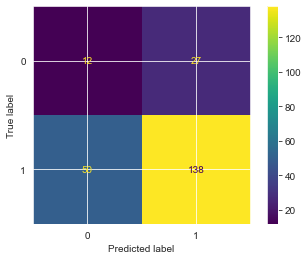

In [8]:
def is_active_no_ge_prefix(headline):
    # Check if any word in headline start with "ge"
    for word in headline.split():
        if word == "door" or word == "Door":
            return False
        if "word" in word or word in ["zijn", "is", "ben", "bent"]:  # Check for any form of the verb "worden"
            return False
    return True


from util import print_evaluation
import numpy as np

predictions = np.vectorize(is_active_no_ge_prefix)(test_x)
print_evaluation(test_y, predictions)

## Approach 2: Past particle using spacy

In [9]:
import spacy
from pprint import pprint

nlp = spacy.load('nl_core_news_sm')
pprint(list([(x.text, x.pos_, x.tag_) for x in nlp("Verdachte gevlucht na overval")]))

[('Verdachte', 'PROPN', 'N|eigen|mv|basis'),
 ('gevlucht', 'VERB', 'WW|vd|vrij|zonder'),
 ('na', 'ADP', 'VZ|init'),
 ('overval', 'NOUN', 'N|soort|ev|basis|zijd|stan')]


In [10]:
def contains_past_partiple(headline):
    return any('|vd|' in x.tag_ for x in nlp(headline))


def is_active_pp_spacy(headline):
    return not contains_past_partiple(headline)


print(is_active_pp_spacy(u"Slachtoffer is vermoord in Antwerpen"))
print(is_active_pp_spacy(u"Verdachte pleegt moord in Antwerpen"))

False
True


f-score: 0.7976878612716763
Confusion matrix: (TP: 19, FP: 20, FN: 50, TN: 138)
Accuracy=69.16% (157/227)


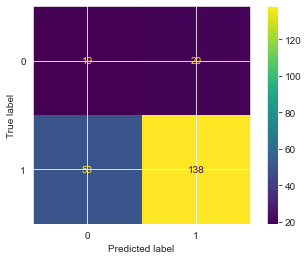

In [11]:
predictions = np.vectorize(is_active_pp_spacy)(test_x)
print_evaluation(test_y, predictions)

## Approach 3: Tf-idf
Passive sentences often contain chargrams like "ge-", "-d", "-t", "door" or forms of "zijn". Because of this, word or character tokenized tf-idf might work well.


### Word-tokenized

f-score: 0.9104116222760291
Confusion matrix: (TP: 2, FP: 37, FN: 0, TN: 188)
Accuracy=83.70% (190/227)


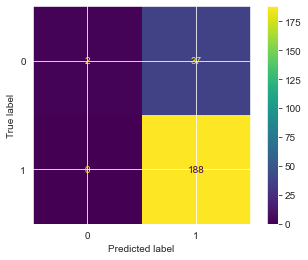

In [12]:
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

model = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('classifier', svm.LinearSVC(random_state=42))
])

model.fit(train_x, train_y)

prediction = model.predict(test_x)
print_evaluation(test_y, prediction)

In [13]:
from util import show_most_informative_features
show_most_informative_features(model)

0.6746          geeft    -1.1450       opgepakt
0.6557           onze    -1.1117           twee
0.6219     vlaanderen    -0.9961             dj
0.5266        politie    -0.9316          omdat
0.5241           auto    -0.9222   geschiedenis
0.5208            dag    -0.8955       verdacht
0.5151            uit    -0.8497           belg
0.5147     temptation    -0.7925           drie
0.4945            mee    -0.7915         avicii
0.4936           niet    -0.7867      favoriete


Those are not what I expected (I expected more past particles on th negative side, "verdacht" and "opgepakt" are the only ones in the top 10). "Door" is also a logical one on the negative side (but dissapeared because the random seed wasn't fixed).

### Character-tokenized

f-score: 0.9029126213592233
Confusion matrix: (TP: 1, FP: 38, FN: 2, TN: 186)
Accuracy=82.38% (187/227)


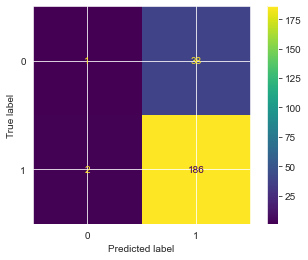

In [14]:
model = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer="char_wb", ngram_range=(1, 4))), # "-d" to "door"
    ('classifier', svm.LinearSVC(random_state=42))
])

model.fit(train_x, train_y)

prediction = model.predict(test_x)
print_evaluation(test_y, prediction)

Let's take a look at which characters are important:

In [15]:
show_most_informative_features(model)

0.6202              "    -0.7030             ak
0.6182              l    -0.6778            era
0.5283            ag     -0.6535            ng 
0.4911              o    -0.5590            erd
0.4901             la    -0.5581              d
0.4803            lt     -0.5506             u 
0.4797            laa    -0.5401            doo
0.4633             on    -0.5361              g
0.4527             bl    -0.5329            ot 
0.4329           aan     -0.5085             be


"doo(r)" was expectd. " ge-" is surprisingly not part of the top 10 negatives (but "gel-" is). "-erd" is also one that makes sense.

## Approach 4: char-gram Tf-idf + past particle as extra feature

f-score: 0.9051094890510949
Confusion matrix: (TP: 2, FP: 37, FN: 2, TN: 186)
Accuracy=82.82% (188/227)


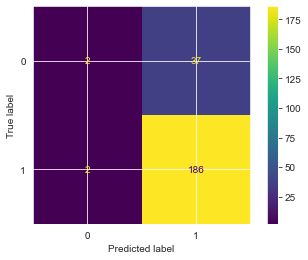

In [17]:
from sklearn.pipeline import FeatureUnion
from util import FunctionTransformer

model = Pipeline([
    ('union', FeatureUnion([
        ('vectorizer', TfidfVectorizer(analyzer="char_wb", ngram_range=(1, 4))),
        ('consecutive_pronouns', FunctionTransformer(func=is_active_pp_spacy))
    ])),
    ('classifier', svm.LinearSVC(random_state=0))
])

model.fit(train_x, train_y)

prediction = model.predict(test_x)
print_evaluation(test_y, prediction)

Surprisingly, this doesn't give any increase.

## Approach 5: word-gram tf-idf + past particle as extra feature

f-score: 0.9077669902912622
Confusion matrix: (TP: 2, FP: 37, FN: 1, TN: 187)
Accuracy=83.26% (189/227)


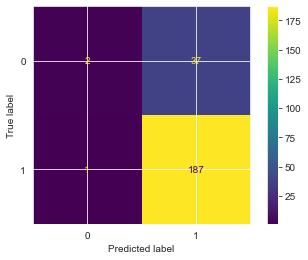

In [18]:
from sklearn.pipeline import FeatureUnion
from util import FunctionTransformer

model = Pipeline([
    ('union', FeatureUnion([
        ('vectorizer', TfidfVectorizer()),
        ('consecutive_pronouns', FunctionTransformer(func=is_active_pp_spacy))
    ])),
    ('classifier', svm.LinearSVC(random_state=0))
])

model.fit(train_x, train_y)

prediction = model.predict(test_x)
print_evaluation(test_y, prediction)